### Validating Areal Interpolation

The purpose of this notebook is to demonstrate that our areal interpolation functions produce extensive and intensive statistics similar to known values.

We're also assessing the performance of the simple tracts-to-community-areas crosswalk contained in `data/tracts_comm_areas.csv`, which was generated based on the Chicago Data Portal's community_area attribute of [tract shapefiles](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Census-Tracts-2010/5jrd-6zik).

In [1]:
import sys

# others will need to change the below line to point at broadbandequity directory
# this is necessary so that the jupyternotebook can load our package
sys.path[0] = '/Users/drewkeller/Desktop/CS/broadbandequity'

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from data_pipeline.fetch_census_data import acs5_aggregate 
from data_pipeline import spatial_operations as so
import numpy as np
import pandas as pd
from IPython.display import display

We will use ACS 5-year aggregate data from 2019 for our validation. We are comparing to known values from CMAP that also rely on aggregated ACS data:

"CCA values are estimated by aggregating ACS data for census tracts and block groups. Data from tracts and block groups located in multiple CCAs is allocated proportionally based on the block-level distribution of population, households or housing units (as appropriate) from the most recent Decennial Census."

Our approach:
1. Start with tract-level population data from ACS.
2. Calculate tract-level population density using tract shapefiles.
3. Aggregate tract-level population to community areas via areal-weighted sum.
4. Aggregate tract-level density to community areas via areal-weighted mean. Multiply by community-area area to get population.
5. Aggregate tract-level density to community areas via population-weighted mean. Multiply by community-area area to get population. _Note: Realized retroactively that this is invalid and results in upward bias - density inherently should be weighted by area, not population. To validate population-weighted mean we would need to use another known statistic like income._
6. Compare calculated populations to known values (Source: [CMAP: 2021 CDS based on 2019 population data](https://datahub.cmap.illinois.gov/dataset/community-data-snapshots-raw-data)).

In [3]:
# 1. Start with tract-level population data from ACS.
tract_data = acs5_aggregate()[["estimated total population","tract"]]
tract_data['population'] = tract_data['estimated total population']
tract_data = tract_data.drop(columns='estimated total population')
tract_data.head()

,tract,population
0,630200,1825
1,580700,5908
2,590600,3419
3,600700,2835
4,611900,1639


In [4]:
# 2. Calculate tract-level population density using tract shapefiles.
tract_data = so.geographize(tract_data,'tract')
tract_data["density"] = tract_data['population']/tract_data.area
tract_data.head()

,Shape_Leng,Shape_Area,SqMiles,GEOID2,tract,geometry,population,area,density
0,6102.900390,1.777035e+06,0.000000,76840801,840801,"MULTIPOLYGON (((-87.92000 41.95815, -87.92000 ...",NaN,0.000018,NaN
1,16035.054991,8.947394e+06,0.320945,59840300,840300,"POLYGON ((-87.67528 41.83039, -87.67552 41.830...",3511.0,0.000090,3.897121e+07
2,14719.012184,8.946045e+06,0.320896,60840200,840200,"POLYGON ((-87.64160 41.84630, -87.64159 41.846...",2419.0,0.000090,2.684937e+07
3,15186.400644,1.230614e+07,0.441424,34841100,841100,"POLYGON ((-87.62935 41.85295, -87.62935 41.852...",7142.0,0.000124,5.762165e+07
4,10472.230299,6.731931e+06,0.241476,31841200,841200,"POLYGON ((-87.67849 41.85894, -87.67848 41.858...",4586.0,0.000068,6.763118e+07


In [5]:
# 3. Aggregate tract-level population to community areas via areal-weighted sum.
community_pop = so.aggregate(tract_data,{'population' : 'areal sum'},'community_area','tract')
community_pop.head()

,community_area,population
0,ALBANY PARK,49961.187369
1,ARCHER HEIGHTS,13813.723726
2,ARMOUR SQUARE,13615.528727
3,ASHBURN,43495.864359
4,AUBURN GRESHAM,45990.553683


In [6]:
# 4. Aggregate tract-level density to community areas via areal-weighted mean. Multiply by community-area area to get population.
community_density_areal = so.geographize(so.aggregate(tract_data,{'density' : 'areal mean'},'community_area','tract'),'community_area')
community_density_areal['population'] = community_density_areal['density']*community_density_areal['area']
community_density_areal = community_density_areal[['community_area','population']]
community_density_areal.head()

,community_area,population
0,DOUGLAS,21345.175153
1,OAKLAND,7214.078422
2,FULLER PARK,2393.597346
3,GRAND BOULEVARD,22649.181998
4,KENWOOD,17936.426772


In [7]:
# 5. Aggregate tract-level density to community areas via population-weighted mean. Multiply by community-area area to get population.
community_density_pop = so.geographize(so.aggregate(tract_data,{'density' : 'pop mean'},'community_area','tract'),'community_area')
community_density_pop['population'] = community_density_pop['density']*community_density_pop['area']
community_density_pop = community_density_pop[['community_area','population']]
community_density_pop.head()

,community_area,population
0,DOUGLAS,23112.192751
1,OAKLAND,7449.861845
2,FULLER PARK,2634.166334
3,GRAND BOULEVARD,25133.296730
4,KENWOOD,19791.706606


In [8]:
# 6. Compare calculated populations to known values 

# first step: load validation data
validation_data = pd.read_csv('../data/CMAP_2019_comm_data.csv')[['GEOG','TOT_POP']]
validation_data['GEOG'] = [str(i).upper() for i in validation_data['GEOG']]
validation_data = validation_data.rename(columns={'GEOG':'community_area','TOT_POP':'known population'})
validation_data['community_area'] = validation_data['community_area'].replace({"O'HARE":"OHARE","THE LOOP": "LOOP"})
validation_data = validation_data.dropna()
validation_data.head()

,community_area,known population
0,ALBANY PARK,49805.99998
1,ARCHER HEIGHTS,13700.97018
2,ARMOUR SQUARE,13598.48056
3,ASHBURN,43355.99999
4,AUBURN GRESHAM,45909.00001


In [9]:
# second step: place calculated and known values side-by-side with errors
community_pop = community_pop.rename(columns={'population':'areal-weighted sum'})
community_density_areal = community_density_areal.rename(columns={'population':'areal-weighted mean'})
community_density_pop = community_density_pop.rename(columns={'population':'pop-weighted mean'})
validation_data = validation_data.join(community_pop.set_index('community_area'),on='community_area')
validation_data['areal-weighted sum error'] = validation_data['areal-weighted sum']-validation_data['known population']
validation_data = validation_data.join(community_density_areal.set_index('community_area'),on='community_area')
validation_data['areal-weighted mean error'] = validation_data['areal-weighted mean']-validation_data['known population']
validation_data = validation_data.join(community_density_pop.set_index('community_area'),on='community_area')
validation_data['pop-weighted mean error'] = validation_data['pop-weighted mean']-validation_data['known population']
validation_data.head()

,community_area,known population,areal-weighted sum,areal-weighted sum error,areal-weighted mean,areal-weighted mean error,pop-weighted mean,pop-weighted mean error
0,ALBANY PARK,49805.99998,49961.187369,155.187389,49961.187369,155.187389,56917.734789,7111.734809
1,ARCHER HEIGHTS,13700.97018,13813.723726,112.753546,13813.723726,112.753546,23458.528742,9757.558562
2,ARMOUR SQUARE,13598.48056,13615.528727,17.048167,13615.528727,17.048167,15599.961772,2001.481212
3,ASHBURN,43355.99999,43495.864359,139.864369,43512.155166,156.155176,49005.416593,5649.416603
4,AUBURN GRESHAM,45909.00001,45990.553683,81.553673,45990.553683,81.553673,49527.006769,3618.006759


In [10]:
# fourth step: add simple crosswalk

crosswalk = pd.read_csv("../data/chicago_internet.csv")[['name','total_pop']]
crosswalk['name'] = [str(i).upper() for i in crosswalk['name']]
crosswalk = crosswalk.rename(columns={'name':'community_area','total_pop':'crosswalk'})
crosswalk = crosswalk.replace({"O'HARE":"OHARE"})
validation_data = validation_data.join(crosswalk.set_index('community_area'),on='community_area')
validation_data['crosswalk error'] = validation_data['crosswalk']-validation_data['known population']

In [11]:
# third step: stats

print('Areal-weighted sum:')
print(f'Maximum error: {max(abs(validation_data["areal-weighted sum error"]))}')
print(f'Median error: {np.nanmedian(validation_data["areal-weighted sum error"])}')
print(f'Mean error: {np.mean(validation_data["areal-weighted sum error"])}')
print(f'RMS error: {np.sqrt(np.nanmean(validation_data["areal-weighted sum error"]**2))}')
outliers5 = sum([1 if abs(i)>0.05 else 0 for i in validation_data['areal-weighted sum error']/validation_data['known population']])
outliers20 = sum([1 if abs(i)>0.2 else 0 for i in validation_data['areal-weighted sum error']/validation_data['known population']])
print(f'Community areas off by more than 5%, 20%: {outliers5},{outliers20}')
print('')

print('Areal-weighted mean:')
print(f'Maximum error: {max(abs(validation_data["areal-weighted mean error"]))}')
print(f'Median error: {np.nanmedian(validation_data["areal-weighted mean error"])}')
print(f'Mean error: {np.mean(validation_data["areal-weighted mean error"])}')
print(f'RMS error: {np.sqrt(np.nanmean(validation_data["areal-weighted mean error"]**2))}')
outliers5 = sum([1 if abs(i)>0.05 else 0 for i in validation_data['areal-weighted mean error']/validation_data['known population']])
outliers20 = sum([1 if abs(i)>0.2 else 0 for i in validation_data['areal-weighted mean error']/validation_data['known population']])
print(f'Community areas off by more than 5%, 20%: {outliers5},{outliers20}')
print('')

print('Pop-weighted mean:')
print(f'Maximum error: {max(abs(validation_data["pop-weighted mean error"]))}')
print(f'Median error: {np.nanmedian(validation_data["pop-weighted mean error"])}')
print(f'Mean error: {np.mean(validation_data["pop-weighted mean error"])}')
print(f'RMS error: {np.sqrt(np.nanmean(validation_data["pop-weighted mean error"]**2))}')
outliers5 = sum([1 if abs(i)>0.05 else 0 for i in validation_data['pop-weighted mean error']/validation_data['known population']])
outliers20 = sum([1 if abs(i)>0.2 else 0 for i in validation_data['pop-weighted mean error']/validation_data['known population']])
print(f'Community areas off by more than 5%, 20%: {outliers5},{outliers20}')
print('')

print('Simple crosswalk:')
print(f'Maximum error: {max(abs(validation_data["crosswalk error"]))}')
print(f'Median error: {np.median(validation_data["crosswalk error"])}')
print(f'Mean error: {np.mean(validation_data["crosswalk error"])}')
print(f'RMS error: {np.sqrt(np.nanmean(validation_data["crosswalk error"]**2))}')
outliers5 = sum([1 if abs(i)>0.05 else 0 for i in validation_data['crosswalk error']/validation_data['known population']])
outliers20 = sum([1 if abs(i)>0.2 else 0 for i in validation_data['crosswalk error']/validation_data['known population']])
print(f'Community areas off by more than 5%, 20%: {outliers5},{outliers20}')

Areal-weighted sum:
Maximum error: 7270.164365135533
Median error: 12.26601474578274
Mean error: 359.4319447736419
RMS error: 1548.5802739096082
Community areas off by more than 5%, 20%: 7,3

Areal-weighted mean:
Maximum error: 7270.5880953563465
Median error: 22.27624255095361
Mean error: 365.7518816814698
RMS error: 1550.8153829256369
Community areas off by more than 5%, 20%: 7,3

Pop-weighted mean:
Maximum error: 17676699.84644796
Median error: 6642.9891447367845
Mean error: 282229.9458693331
RMS error: 2052979.9902568774
Community areas off by more than 5%, 20%: 68,35

Simple crosswalk:
Maximum error: 6046.38276
Median error: 0.0
Mean error: 192.82476575324677
RMS error: 1053.2252118963247
Community areas off by more than 5%, 20%: 4,1


Discussion:

Areal-weighted sum and mean produce very similar results, as expected. (Actually, in many cases, precisely the same results.) Both are within a few hundred residents of our validation data for most neighborhoods, but both have a handful of neighborhoods that they underestimate by up to 10,000 residents.

This is definitely cause for concern, but perhaps for a more complicated reason than the aggregation function not working, as the low median error and clustering of most results near the known value seem to suggest that the aggregation function likely works (unless the overlapping-measurement part is broken and the outliers have more overlapping tracts?).

Population-weighted mean overestimates _most_ neighborhoods by several thousand residents. On reflection, this is actually expected behavior because it's not really valid to take a population-weighted mean of population density; it makes sense that this would bias population results upwards. In other words, these results suggest the population-weighted mean function is working, but to confirm we may need to use a different validation variable.

The simple crosswalk method - one-to-one from tracts to community areas - performs best by a signficant amount. In fact, a majority (48/77) community areas obtain the exact value from this method! 

This does raise some questions. Are those 48/77 community areas ones in which tract boundaries align exactly? If so this result could make sense, although it would then be concerning why the aggregation function also didn't give exact results. The next step may be to inspect one of these community areas in depth to see if we can identify what is going on.

In [12]:
# save to CSV
validation_data.to_csv('validation_data')

In [13]:
# display in full
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(validation_data.round().convert_dtypes(convert_integer=True))

,community_area,known population,areal-weighted sum,areal-weighted sum error,areal-weighted mean,areal-weighted mean error,pop-weighted mean,pop-weighted mean error,crosswalk,crosswalk error
0,ALBANY PARK,49806,49961,155,49961,155,56918,7112,49806,0
1,ARCHER HEIGHTS,13701,13814,113,13814,113,23459,9758,13726,25
2,ARMOUR SQUARE,13598,13616,17,13616,17,15600,2001,13538,-60
3,ASHBURN,43356,43496,140,43512,156,49005,5649,43356,0
4,AUBURN GRESHAM,45909,45991,82,45991,82,49527,3618,45909,0
5,AUSTIN,93727,93915,188,93925,198,118396,24669,93727,0
6,AVALON PARK,9671,9596,-75,9596,-75,9644,-26,9713,42
7,AVONDALE,38118,38126,8,38126,8,42107,3989,38118,0
8,BELMONT CRAGIN,78550,78624,74,78624,74,83727,5177,78601,51
9,BEVERLY,19791,19848,57,19849,58,21031,1240,19791,0


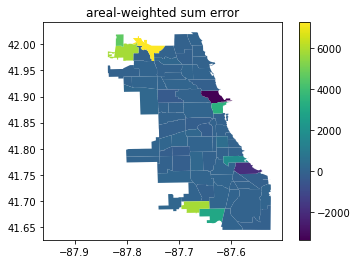

In [14]:
so.simple_map(validation_data,'areal-weighted sum error','community_area')

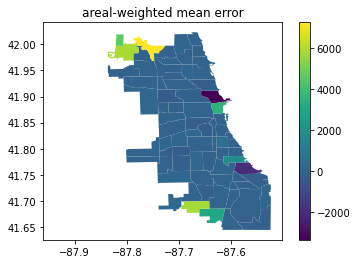

In [15]:
so.simple_map(validation_data,'areal-weighted mean error','community_area')

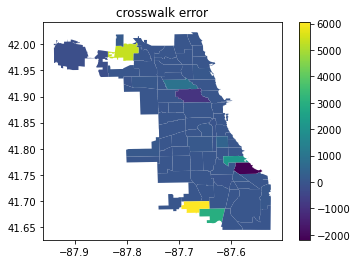

In [16]:
so.simple_map(validation_data,'crosswalk error','community_area')

Mapping reveals that a number of the errors are due to the validation dataset assigning certain tract(s) on the boundaries of community areas differently than suggested by the Chicago Data Portal community area shapefiles:
- CMAP includes a tract in South Shore that Chicago Data Portal sources place in Woodlawn. So, all three of our aggregation methods show higher Woodlawn population and lower South Shore population relative to CMAP.
- The Chicago Data Portal crosswalk places a populous tract in Logan Square that CMAP and the Chicago Data Portal shapefiles allocate a significant portion of to West Town.
- The Chicago Data Portal shapefiles imply significantly more people in Forest Glen and Edison Park than the crosswalk and CMAP. All Chicago Data Portal sources imply more people in Norwood Park than CMAP. All Chicago Data Portal sources, especially the crosswalk, imply more people in Morgan Park and West Pullman than CMAP.

Other than those differences, all sources agree quite closely.